# This notebook shows how to generate alpha shape based on a .pdb file (or .cif), taking 4UG0 as an example.


## Step 1: load file as a point cloud

In [11]:
from Bio.PDB import PDBParser
import numpy as np

def pdb_to_point_cloud(pdb_file):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("structure", pdb_file)
    point_cloud = []

    for atom in structure.get_atoms():
        coord = atom.coord  # Get x, y, z coordinates
        point_cloud.append(coord)

    return point_cloud


from Bio.PDB.MMCIFParser import MMCIFParser

# Load the CIF file
parser = MMCIFParser()

def cif_to_point_cloud(cif_file):
    structure = parser.get_structure("structure", cif_file)

# Extract atomic coordinates
    coordinates = []
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    coordinates.append(atom.coord)  # Get Cartesian coordinates
                    
    return coordinates



# Example usage for PDB file
# pdb_file = "../data/4UG0/4ug0_edited.pdb"
# point_cloud = pdb_to_point_cloud(pdb_file)
# point_cloud = np.array(point_cloud)
# print(point_cloud.shape)

# Example usage for CIF
cif_file = "../data/6WD4/6WD4.cif"
# cif_file = "../data/4UG0/4UG0.cif"
point_cloud = cif_to_point_cloud(cif_file)
point_cloud = np.array(point_cloud)
print(point_cloud.shape)

(153083, 3)


/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain 5 is discontinuous at line 153034.
  warnings.warn(
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain 7 is discontinuous at line 153044.
  warnings.warn(
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain 8 is discontinuous at line 153055.
  warnings.warn(


A visualization of the point cloud:

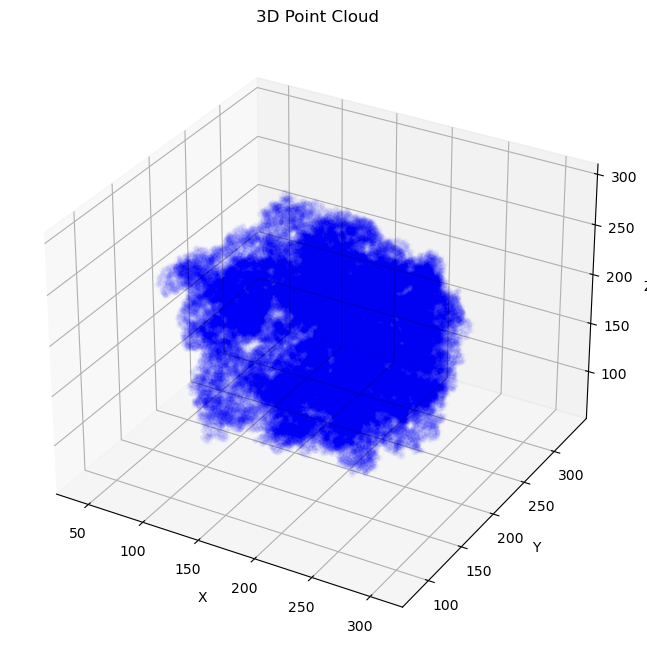

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
point_cloud = np.array(point_cloud)
    
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2],
               s=10, c='blue', alpha=0.02)

# Set labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3D Point Cloud")

plt.show()

## Step 2: generate an alpha shape using alphashape package

In [13]:
import alphashape
import trimesh
alpha_shape = alphashape.alphashape(point_cloud,  alpha=0.04)
alpha_shape.show()

## Step 3: save alpha shape as .ply

In [14]:
import trimesh

def save_alpha_shape_as_ply(alpha_shape, file_path):
    """
    Save a Trimesh alpha shape as a PLY file.

    Args:
        alpha_shape: A Trimesh object representing the alpha shape.
        file_path: The output file path for the PLY file.
    """
    if not isinstance(alpha_shape, trimesh.Trimesh):
        raise TypeError("avislpha_shape must be a trimesh.Trimesh object.")
    
    # Save as PLYencoding='ascii'
    alpha_shape.export(file_path, file_type='ply',encoding='ascii')
    print(f"Alpha shape saved as PLY file at {file_path}")

# Example usage
# Assuming `alpha_shape` is a trimesh.Trimesh object

save_alpha_shape_as_ply(alpha_shape, "../data/6WD4/alpha_shape_6WD4.ply")
# Load and verify the PLY file
alpha_shape = trimesh.load("../data/6WD4/alpha_shape_6WD4.ply")
print(alpha_shape)
alpha_shape.show() 

Alpha shape saved as PLY file at ../data/6WD4/alpha_shape_6WD4.ply
<trimesh.Trimesh(vertices.shape=(2388, 3), faces.shape=(4566, 3), name=`alpha_shape_6WD4.ply`)>


## Optional refinement: The previous alpha shape can be improved by the following steps
- Tune hyperparameter in alpha shapes. Previously I used alpha=0.04. Here's what it looks like for other values:

In [13]:

fig = plt.figure(figsize=(12, 3))

for i,alpha in enumerate([0.02,0.04,0.1,0.15,0.3]):
    alpha_shape_tune = alphashape.alphashape(point_cloud, alpha)
    
    alpha_shape_vertices = alpha_shape_tune.vertices  # Replace with actual alpha shape vertices
    alpha_shape_faces = alpha_shape_tune.faces  # Replace with actual alpha shape faces
    ax = fig.add_subplot(1,5,i+1, projection='3d')


    # Plot the alpha shape mesh
    ax.plot_trisurf(alpha_shape_vertices[:, 0], alpha_shape_vertices[:, 1], alpha_shape_vertices[:, 2], 
                    triangles=alpha_shape_faces, color='lightblue', alpha=0.1, edgecolor='gray')
    
    # Set labels and title
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(str(alpha))

# Show the plot
plt.show()

- Remove the small floating pieces in alph shape: The alpha shape constructed above may contain multiple components where some of them are just floating triangle pieces. One may want to keep the shape with largest volume only

In [15]:
components = alpha_shape.split(only_watertight=False)  # Get all components
# Print number of components (only one of them is the shape and all the rest are small pieces due to artifact)
print( len(components) )
# Find the largest component based on volume
alpha_shape_largest = max(components, key=lambda c: abs(c.volume) )
alpha_shape_largest.show()

102


- If the surface needs to be watertight, it can be often be achieved by sampling inside and re-computing alpha shape

In [16]:
def sample_within_alpha_shape(alpha_shape_mesh, num_samples=1000):
    """
    Samples points within the boundaries of a 3D alpha shape.

    Parameters:
    - alpha_shape_mesh: trimesh.Trimesh
        The alpha shape mesh that defines the 3D boundaries.
    - num_samples: int
        The number of points to sample within the alpha shape.

    Returns:
    - sampled_points: np.ndarray
        Array of sampled points within the alpha shape of shape (num_samples, 3).
    """
    # Get the bounding box of the alpha shape
    bbox_min, bbox_max = alpha_shape_mesh.bounds

    # Generate random points within the bounding box
    sampled_points = []
    while len(sampled_points) < num_samples:
        # Generate random points within the bounding box
        points = np.random.uniform(low=bbox_min, high=bbox_max, size=(num_samples * 2, 3))

        # Use trimesh's built-in point-in-mesh test to filter points inside the alpha shape
        #print( alpha_shape_mesh.contains(points).shape )
        inside = alpha_shape_mesh.contains(points) #* (not tunnel_mesh.contains(points)[0])

        # Add points that are inside the shape to the sampled list
        sampled_points.extend(points[inside])
        print(len(sampled_points))
    # Return the requested number of samples
    return np.array(sampled_points)
import random

random.seed(10)
new_points = sample_within_alpha_shape(alpha_shape_largest,num_samples=4000)


2558
5242


In [17]:
print( alpha_shape_largest.is_watertight )
alpha = 0.04
# np.concatenate( (point_cloud,new_points))
alpha_shape_renew = alphashape.alphashape( np.concatenate( (alpha_shape_largest.vertices,new_points)), alpha)
# alpha_shape_renew = alphashape.alphashape( new_points, alpha)
# The new mesh is often watertight
print( alpha_shape_renew.is_watertight )
alpha_shape_renew.show()
save_alpha_shape_as_ply(alpha_shape_renew, "../data/6WD4/alpha_shape_watertight_6WD4.ply")
# Load and verify the PLY file
#alpha_shape_renew = trimesh.load("../data/6WD4/alpha_shape_6WD4.ply")
# print(alpha_shape)
# alpha_shape.show() 

False
True
Alpha shape saved as PLY file at ../data/6WD4/alpha_shape_watertight_6WD4.ply


Sanity check to see if it indeed includes all points from the structure

In [18]:
for i in range(0,100000,10):
    if i % 1000 == 0:
        print(i)
    if alpha_shape_renew.contains(point_cloud[i:i+10,:]).any == False:
        print('outside')
    # else:
    #     print('good')

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000


- Clip the tunnel mesh using alpha shape (this is not precise and result in messy boundaries)

In [19]:
stl_mesh = trimesh.load("../data/4UG0/4UG0_poisson_recon_ascii.ply")
stl_mesh.fix_normals()

stl_mesh.fill_holes()
stl_mesh_original = stl_mesh

inside_mask = alpha_shape_renew.contains(stl_mesh.vertices)

filtered_vertices = stl_mesh.vertices[inside_mask]

# Step 2: Find valid faces where all vertices are still present
# Create a mapping from old vertex indices to new indices
vertex_map = {old_idx: new_idx for new_idx, old_idx in enumerate(np.where(inside_mask)[0])}

# Filter faces: A face is valid if all its vertices are in the filtered set
valid_faces = []
for face in stl_mesh.faces:
    if all(v in vertex_map for v in face):
        valid_faces.append([vertex_map[v] for v in face])

valid_faces = np.array(valid_faces)


# Create a new mesh from the filtered vertices and the original faces
stl_mesh = trimesh.Trimesh(vertices=filtered_vertices, faces=valid_faces)# # Remove vertices of mesh1 that are inside mesh2

inside_mask = alpha_shape_renew.contains(stl_mesh.vertices)

filtered_vertices = stl_mesh.vertices[inside_mask]

# Step 2: Find valid faces where all vertices are still present
# Create a mapping from old vertex indices to new indices
vertex_map = {old_idx: new_idx for new_idx, old_idx in enumerate(np.where(inside_mask)[0])}

# Filter faces: A face is valid if all its vertices are in the filtered set
valid_faces = []
for face in stl_mesh.faces:
    if all(v in vertex_map for v in face):
        valid_faces.append([vertex_map[v] for v in face])

valid_faces = np.array(valid_faces)


# Create a new mesh from the filtered vertices and the original faces
stl_mesh = trimesh.Trimesh(vertices=filtered_vertices, faces=valid_faces)# # Remove vertices of mesh1 that are inside mesh2

components = stl_mesh.split(only_watertight=False)  # Get all components
stl_mesh = max(components, key=lambda c: abs(c.volume) )

stl_mesh.show()

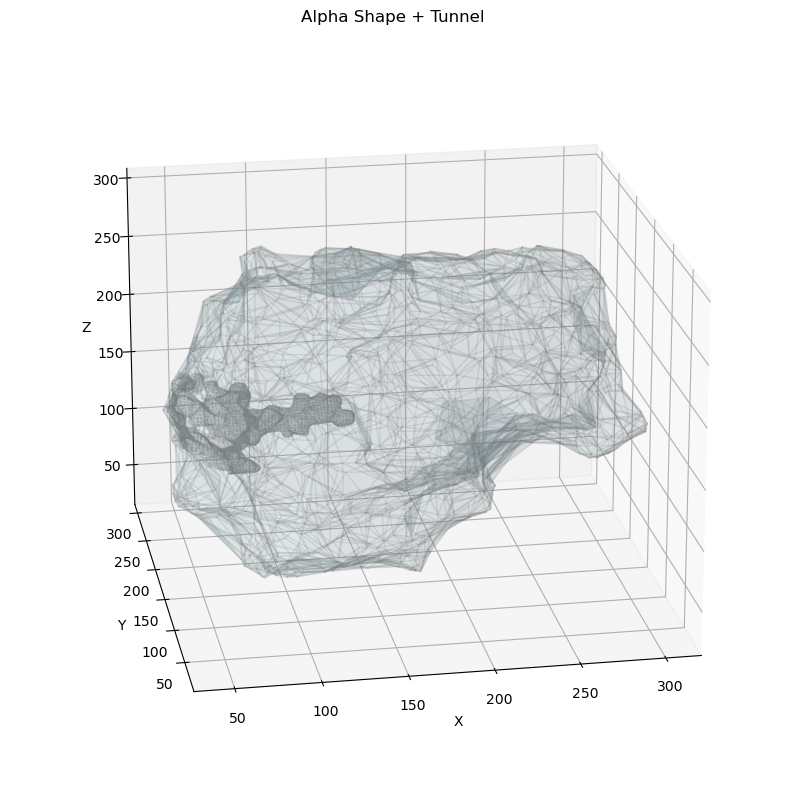

In [21]:
stl_mesh.visual.vertex_colors = np.tile([150/256,0,0, 0.3], (len(stl_mesh.vertices), 1))  # Red, opaque
alpha_shape_renew.visual.vertex_colors = np.tile([0,0,150/256, 0.3], (len(alpha_shape_renew.vertices), 1))  # Blue, opaque

merged_mesh_renew = trimesh.util.concatenate([stl_mesh,alpha_shape_renew] )

# Extract the vertices and faces from the STL mesh
merged_vertices = merged_mesh_renew.vertices  # All vertices of the STL file
merged_faces = merged_mesh_renew.faces  # Faces (triangles)

# Plot both the STL mesh and the alpha shape
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')


# Plot the merged shape mesh
ax.plot_trisurf(merged_vertices[:, 0], merged_vertices[:, 1], merged_vertices[:, 2], 
                triangles=merged_faces, color='lightblue', alpha=0.1, edgecolor='gray')



# Set the axes limits (optional, adjust to your data range)
all_vertices = merged_vertices
ax.set_xlim([all_vertices[:, 0].min(), all_vertices[:, 0].max()])
ax.set_ylim([all_vertices[:, 1].min(), all_vertices[:, 1].max()])
ax.set_zlim([all_vertices[:, 2].min(), all_vertices[:, 2].max()])

# Set labels and title
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Alpha Shape + Tunnel ")
ax.view_init(20, -100)
# Show the plot
plt.show()




#save_alpha_shape_as_ply(merged_mesh_final, "../data/alpha_shapes/4UG0/merged.ply")